## Module Import & Data Load

In [1]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from src import dataset

import pickle
from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [4]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [6]:
TRAIN_DATASET = sorted([x for x in Path("HAICon2021_dataset/train/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('HAICon2021_dataset/train/train1.csv'),
 PosixPath('HAICon2021_dataset/train/train2.csv'),
 PosixPath('HAICon2021_dataset/train/train3.csv'),
 PosixPath('HAICon2021_dataset/train/train4.csv'),
 PosixPath('HAICon2021_dataset/train/train5.csv'),
 PosixPath('HAICon2021_dataset/train/train6.csv')]

In [7]:
TEST_DATASET = sorted([x for x in Path("HAICon2021_dataset/test/").glob("*.csv")])
TEST_DATASET

[PosixPath('HAICon2021_dataset/test/test1.csv'),
 PosixPath('HAICon2021_dataset/test/test2.csv'),
 PosixPath('HAICon2021_dataset/test/test3.csv')]

In [8]:
VALIDATION_DATASET = sorted([x for x in Path("HAICon2021_dataset/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('HAICon2021_dataset/validation/validation.csv')]

In [9]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [10]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,...,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,...,1.16898,35.03488,10.00000,3175.36084,370.40656,1,986.05908,12.0,50,89
259197,2021-08-09 08:59:58,-2.3325,0,12.26196,0.00152,100.28228,0.5425,12.53358,70,1,...,1.16974,35.02840,10.00000,3175.73608,368.12787,1,986.05908,12.0,50,90
259198,2021-08-09 08:59:59,-2.3049,0,12.26196,0.00058,100.26703,0.6266,12.53358,70,1,...,1.16974,35.02420,10.00000,3176.61182,368.01941,1,986.05908,12.0,50,74


In [11]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [12]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [13]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [14]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
259196,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
259197,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
259198,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


In [15]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]


# of valid windows: 100387


{'ts': '2021-07-11 10:01:29',
 'given': tensor([[0.4331, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2761],
         [0.3951, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2752],
         [0.3333, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2749],
         ...,
         [0.3205, 0.0000, 0.0548,  ..., 0.0000, 0.0000, 0.0091],
         [0.4451, 0.0000, 0.0562,  ..., 0.0000, 0.0000, 0.0091],
         [0.3477, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.0091]]),
 'answer': tensor([0.3711, 0.0000, 0.0563, 0.5032, 0.1387, 0.4298, 0.8161, 0.0000, 0.0000,
         0.0000, 0.7223, 0.6224, 0.4866, 0.4075, 0.2524, 0.2907, 0.0000, 0.0000,
         0.0000, 0.3050, 0.4108, 0.0000, 0.3492, 0.6516, 0.0120, 0.0000, 0.3563,
         0.3370, 0.0000, 0.9763, 0.5501, 0.3796, 0.3818, 0.0000, 0.9009, 0.0000,
         0.2097, 0.0000, 0.0000, 0.0249, 0.2642, 0.5416, 0.5994, 0.4009, 0.0021,
         1.0000, 0.5253, 1.0000, 0.0000, 0.2244, 0.4755, 0.0000, 0.4874, 0.0509,
         0.0000, 0.3105, 0.7985, 0.1781, 0.2572, 0.4340, 1.

In [16]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


In [17]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [18]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 86311


{'attack': 0.0,
 'ts': '2021-07-10 00:01:30',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4495,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3742,  0.0000, -0.0423,  ...,  0.0000,  0.0000,  0.0199],
         ...,
         [ 0.4637,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4637,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4752,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090]]),
 'answer': tensor([ 3.2394e-01,  0.0000e+00, -4.0688e-02,  5.5395e-01,  1.4765e-01,
          4.0518e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0476e-01,  5.4933e-01,  4.3357e-01,  5.1551e-01,  3.9176e-01,
          2.2724e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          5.1435e-01,  0.0000e+00,  4.3408e-01,  2.6753e-01,  1.0705e-01,
          0.0000e+00,  4.3857e-01,  3.6767e-01,  0.0000e+00,  9.9556e-01,
          5.8638e-01,  2.9160e-01,  2.1829e-01,  

In [19]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [25]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,...,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,...,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,...,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,...,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,...,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,...,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,...,0.92255,29.45758,2.40398,1026.05530,376.66376,1,1015.06964,12.0,50,22
129597,2021-07-16 23:59:58,-1.5833,0,12.07123,-0.00130,13.64288,0.9984,12.58870,70,1,...,0.92255,29.45034,2.40398,981.37659,377.76691,1,1015.06964,12.0,50,22
129598,2021-07-16 23:59:59,-1.4022,0,12.07123,0.00087,13.62762,1.0595,12.58870,70,1,...,0.92255,29.43088,2.40398,919.62439,378.99664,1,1015.06964,12.0,50,22


In [26]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,...,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.471678,0.0,0.079812,0.499628,0.077046,0.429998,0.711769,0.0,0.0,0.0,...,0.377826,0.099579,0.285153,0.069240,0.404094,0.0,0.393961,0.0,0.0,0.173300
2,0.459304,0.0,0.079812,0.482713,0.077046,0.410346,0.711769,0.0,0.0,0.0,...,0.378191,0.103601,0.285153,0.068779,0.429462,0.0,0.393961,0.0,0.0,0.176731
3,0.458079,0.0,0.079812,0.478654,0.077046,0.408400,0.711769,0.0,0.0,0.0,...,0.379124,0.109204,0.285153,0.068734,0.461282,0.0,0.393961,0.0,0.0,0.178719
4,0.380719,0.0,0.079812,0.515098,0.077046,0.367874,0.711769,0.0,0.0,0.0,...,0.379218,0.109763,0.285153,0.066761,0.472272,0.0,0.393961,0.0,0.0,0.182832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511523,0.0,0.017216,0.516825,0.147339,0.557125,0.711717,0.0,0.0,0.0,...,0.245764,0.130889,0.240398,0.327644,0.529605,0.0,0.539339,0.0,0.0,0.010225
129596,0.512114,0.0,0.017216,0.461690,0.135262,0.557380,0.711717,0.0,0.0,0.0,...,0.241081,0.131212,0.240398,0.320111,0.540804,0.0,0.539339,0.0,0.0,0.010225
129597,0.553332,0.0,0.017216,0.493026,0.133167,0.590276,0.711717,0.0,0.0,0.0,...,0.240613,0.130586,0.240398,0.306708,0.545617,0.0,0.539339,0.0,0.0,0.010225
129598,0.587329,0.0,0.017216,0.519678,0.132821,0.603950,0.711717,0.0,0.0,0.0,...,0.240566,0.128753,0.240398,0.287885,0.550216,0.0,0.539339,0.0,0.0,0.010225


In [27]:
boundary_check(TEST_DF)

(True, True, False)

In [28]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 274533


{'attack': 0.0,
 'ts': '2021-07-10 00:01:30',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4495,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3742,  0.0000, -0.0423,  ...,  0.0000,  0.0000,  0.0199],
         ...,
         [ 0.4637,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4637,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4752,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090]]),
 'answer': tensor([ 3.2394e-01,  0.0000e+00, -4.0688e-02,  5.5395e-01,  1.4765e-01,
          4.0518e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0476e-01,  5.4933e-01,  4.3357e-01,  5.1551e-01,  3.9176e-01,
          2.2724e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          5.1435e-01,  0.0000e+00,  4.3408e-01,  2.6753e-01,  1.0705e-01,
          0.0000e+00,  4.3857e-01,  3.6767e-01,  0.0000e+00,  9.9556e-01,
          5.8638e-01,  2.9160e-01,  2.1829e-01,  

In [29]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory' : True}
trainloader = DataLoader(HAI_DATASET_TRAIN, **params)
params['shuffle'] = False
validloader = DataLoader(HAI_DATASET_VALIDATION, **params)
testloader = DataLoader(HAI_DATASET_TEST, **params)

In [30]:
train_shape = next(iter(trainloader))['given'].shape
print(train_shape)

torch.Size([64, 89, 86])


## Model

In [74]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = (
            embedding_dim, 2 * embedding_dim
        )
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return  x[:,-1,:]

In [75]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y

In [76]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = torch.nn.Linear(self.hidden_dim, n_features)
        self.timedist = TimeDistributed(self.output_layer)
        
    def forward(self, x):
        x=x.reshape(-1,1,self.input_dim).repeat(1,self.seq_len,1)       
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        return self.timedist(x)

In [77]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [93]:
timesteps = train_shape[1]
n_features = train_shape[2]
embedding_dim = 64
model = RecurrentAutoencoder(timesteps, n_features, embedding_dim).to(device)
summary(model, train_shape)

Layer (type:depth-idx)                   Output Shape              Param #
RecurrentAutoencoder                     --                        --
├─Encoder: 1-1                           [64, 64]                  --
│    └─LSTM: 2-1                         [64, 89, 128]             110,592
│    └─LSTM: 2-2                         [64, 89, 64]              49,664
├─Decoder: 1-2                           [64, 89, 86]              --
│    └─LSTM: 2-3                         [64, 89, 64]              33,280
│    └─LSTM: 2-4                         [64, 89, 128]             99,328
│    └─TimeDistributed: 2-5              [64, 89, 86]              --
│    └─Linear: 2-6                       [5696, 86]                11,094
│    └─TimeDistributed: 2                --                        --
│    │    └─Linear: 3-1                  [5696, 86]                (recursive)
Total params: 303,958
Trainable params: 303,958
Non-trainable params: 0
Total mult-adds (G): 1.79
Input size (MB): 1.96
Forwa

In [94]:
optimizer = optim.AdamW(model.parameters())
loss_fn = nn.MSELoss()

In [89]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None):
    
    epoch_loss = 0
    
    model.train() 

    for idx, batch in enumerate(train_data):
        
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
                
        input = batch['given'].to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model.forward(input)
            train_loss = loss_fn(predictions, input)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()
        
        epoch_loss += train_loss.item()
        
    return epoch_loss/len(train_data)

In [90]:
def validation(model, val_data, loss_fn):
    model.eval()
    val_loss = 0
    for idx, batch in enumerate(val_data):
        input = batch['given'].to(device)
        with torch.no_grad():
            predictions = model.forward(input)
            val_loss += loss_fn(predictions, input)
        
    return val_loss.item()/len(val_data)

In [91]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [95]:
%%time
epochs = 1000
history = dict()
best = {"loss": sys.float_info.max}
early_stopping = EarlyStopping(patience=50, verbose=1)
for epoch in range(1, epochs+1):
    epoch_loss = train(model, trainloader, optimizer, loss_fn, use_fp16=True)
    val_loss = validation(model, validloader, loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss) 
    
#     sys.stdout.write(
#         "\r" + f"[Train] Epoch : {epoch:^3}"\
#         f"  Train Loss: {epoch_loss:.4}"\
#         f"  Validation Loss: {val_loss:.4}"\
#                     )
    print(f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Validation Loss: {val_loss:.4}")
    if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = epoch + 1
    if early_stopping.validate(epoch_loss):
        break

[Train] Epoch :  1   Train Loss: 0.0213  Validation Loss: 0.01622
[Train] Epoch :  2   Train Loss: 0.00629  Validation Loss: 0.009605
[Train] Epoch :  3   Train Loss: 0.00255  Validation Loss: 0.005324
[Train] Epoch :  4   Train Loss: 0.001727  Validation Loss: 0.006456
[Train] Epoch :  5   Train Loss: 0.00143  Validation Loss: 0.004029
[Train] Epoch :  6   Train Loss: 0.001217  Validation Loss: 0.003649
[Train] Epoch :  7   Train Loss: 0.001108  Validation Loss: 0.003499
[Train] Epoch :  8   Train Loss: 0.001018  Validation Loss: 0.003373
[Train] Epoch :  9   Train Loss: 0.0009854  Validation Loss: 0.003215
[Train] Epoch : 10   Train Loss: 0.001021  Validation Loss: 0.003242
[Train] Epoch : 11   Train Loss: 0.0009502  Validation Loss: 0.003408
[Train] Epoch : 12   Train Loss: 0.0008839  Validation Loss: 0.003075
[Train] Epoch : 13   Train Loss: 0.000864  Validation Loss: 0.002962
[Train] Epoch : 14   Train Loss: 0.0008555  Validation Loss: 0.002955
[Train] Epoch : 15   Train Loss: 0.0

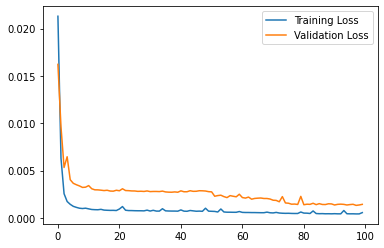

In [96]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [127]:
model.load_state_dict(best["state"])

<All keys matched successfully>

In [100]:
def inference(dataloader, model):
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].to(device)
#             answer = batch["answer"].permute(0,2,1).to(device)
            guess = model(given)
            ts.append(np.array(batch["ts"]))
#             dist.append(torch.abs(given - guess).cpu().numpy())
            dist.append(torch.sum(torch.abs(guess-given), 1).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(64))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [128]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(validloader, model)

CPU times: user 9.58 s, sys: 919 ms, total: 10.5 s
Wall time: 8.47 s


In [129]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [130]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [131]:
CHECK_ATT

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

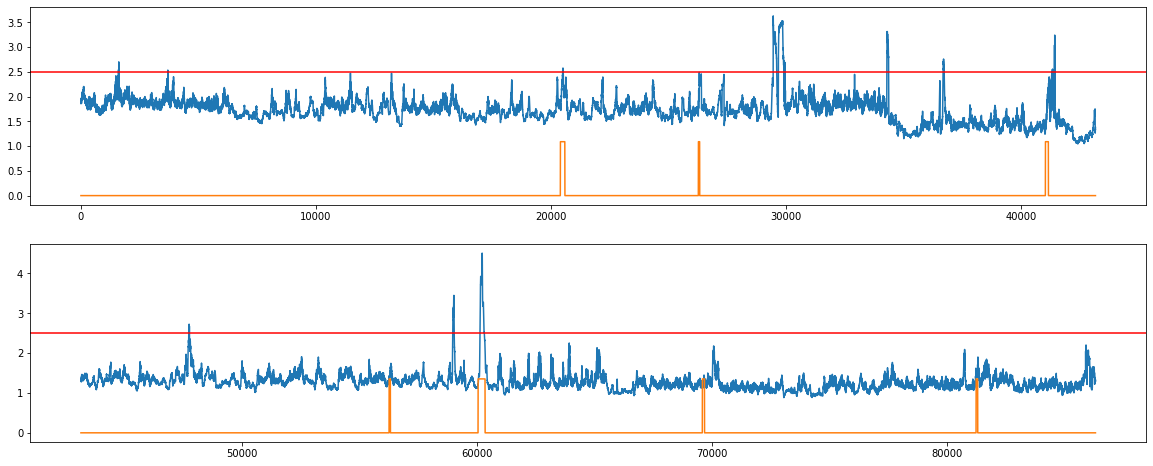

In [132]:
THRESHOLD = 2.5
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [107]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [113]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (86311,))

In [117]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [118]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [119]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 14.8 s, sys: 3.65 ms, total: 14.8 s
Wall time: 14.8 s


(86400,)

In [120]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.105 (TaP: 0.097, TaR: 0.113)
# of detected anomalies: 1
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fb7b1f733c8>]


In [121]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(testloader, model)

CPU times: user 31.1 s, sys: 2.55 s, total: 33.6 s
Wall time: 28.4 s


In [122]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

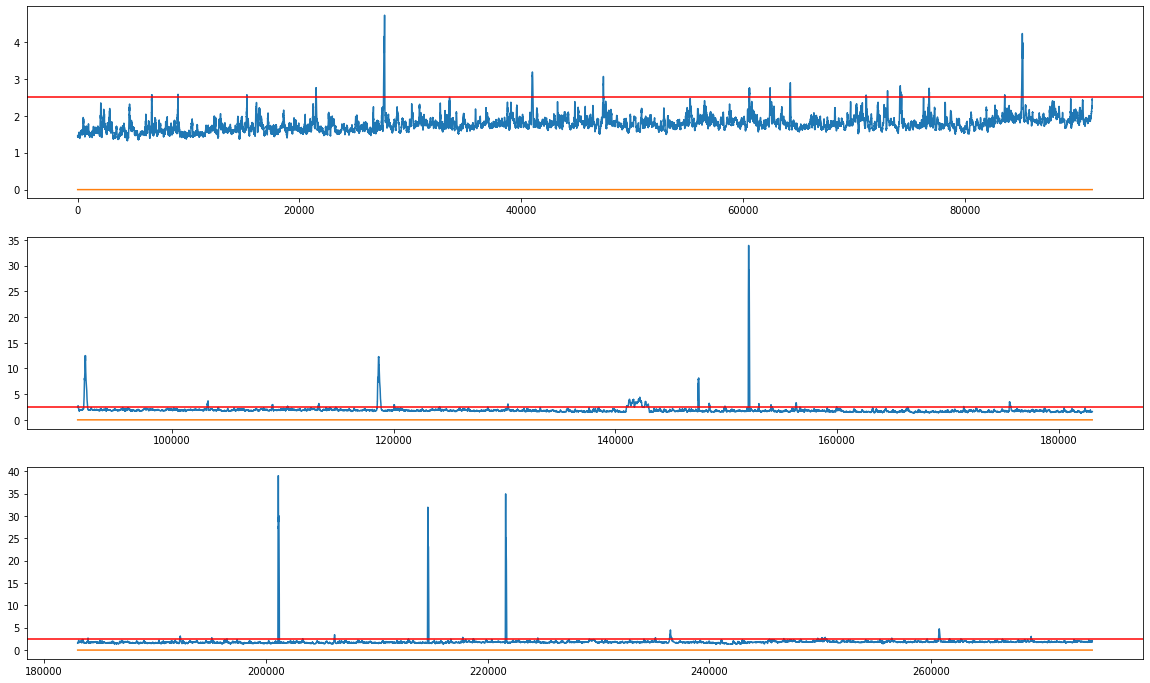

In [123]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [124]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (274533,))

In [125]:
submission = pd.read_csv('./HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [126]:
submission.to_csv('baseline.csv', index=False)